In [1]:
%matplotlib widget

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import sys

In [3]:
names=["TestID", "fuzzingOperationTimes", "staticCollision", "dynamicCollision", "cellTime", "FuzzingOpCount"]

In [4]:
res_col_subset=["fuzzingOperationTimes", "staticCollision", "dynamicCollision"]

In [5]:
# https://stackoverflow.com/questions/68522283/removing-dominated-rows-from-a-pandas-dataframe-rows-with-all-values-lower-th
def get_dominants(df):
    seen = [] # keep track of tested rows
    idx = df.index # initial index
    for i in range(len(df)+1):
        x = idx[0]
        if x in seen:   # done a full loop
            return df.loc[idx]
        seen.append(idx[0])
        # check which rows are dominated and drop them from the index
        idx = (df.loc[idx]-df.loc[x]).le(0).all(axis=1)
        # put tested row at the end
        idx = list(idx[~idx].index)+[x]

def dominant_subset_cols(df):
    return get_dominants(df[res_col_subset])

In [10]:
condbased_res960 = pd.read_csv("steppingcell-condbased-tts-cutdown", delim_whitespace=True)
condbased_res240 = pd.read_csv("tts-history-condfuzz-240", delim_whitespace=True)
condbased_res480 = pd.read_csv("tts-history-condfuzz-480", delim_whitespace=True)
condbased_res720 = pd.read_csv("tts-history-condfuzz-720", delim_whitespace=True)

In [11]:
condbased_res960

,TestID,fuzzingOperationTimes,staticCollision,dynamicCollision,cellTime,FuzzOpCount
0,Test:Test_712_18_08_2023_18_53_57,294.32,180.0,0.0,26.76,2
1,Test:Test_727_18_08_2023_19_52_26,121.04,0.0,32.0,143.24,3
2,Test:Test_800_19_08_2023_00_49_35,93.92,3.0,0.0,167.68,3
3,Test:Test_806_19_08_2023_00_49_35,161.70,6.0,52.0,139.34,3
4,Test:Test_917_19_08_2023_09_06_28,316.80,17.0,0.0,174.62,4
5,Test:Test_952_19_08_2023_11_14_46,172.72,4.0,0.0,183.52,2
6,Test:Test_840_19_08_2023_02_51_12,11.52,3.0,1.0,87.20,2
7,Test:Test_711_18_08_2023_18_53_57,108.00,67.0,2.0,127.34,3
8,Test:Test_694_18_08_2023_17_55_53,105.38,33.0,3.0,101.46,3
9,Test:Test_864_19_08_2023_04_54_24,163.30,10.0,44.0,143.36,3


In [40]:
def plot_3d_resultset(df, df2, graph_title, savefigFilename,xrot,yrot):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')    
    ax.view_init(xrot,yrot)
    ax.scatter(df["staticCollision"], df["dynamicCollision"], abs(df["fuzzingOperationTimes"]))
    
    if not (df2 is None):
        ax.scatter(df2["staticCollision"], df2["dynamicCollision"], abs(df2["fuzzingOperationTimes"]), color="green")

    ax.set_xlabel("Static collision metric")
    ax.set_ylabel("Dynamic collision metric")
    ax.set_zlabel("Fuzzing Operation Times")
    ax.set_title(graph_title)
    plt.tight_layout()
    plt.savefig(savefigFilename)
    plt.show()

In [48]:
def plot_3d_resultset_history_as_subplots(frontDFAttribs, graph_title, savefigFilename, xmax, ymax, zmax):
    labelfont = 8
    titlesize = 10 
    xwidth = 2
    
    vx = 20
    vy = 110
    
    xp = xwidth
    yp = int(len(frontDFAttribs) / xwidth)
    fig = plt.figure()
    default_alpha = 1.0
    
    ai = 1
    for itercount in frontDFAttribs:
        info = frontDFAttribs[itercount]
        df = info["front"]
        col = info["col"]
        title = info["title"]
        ax = fig.add_subplot(xp, yp, ai, projection="3d") 
        ax.scatter(df["staticCollision"], df["dynamicCollision"], df["fuzzingOperationTimes"], c=col, alpha=default_alpha)
        
        ax.view_init(vx,vy)
        ax.set_xlim(0, xmax)
        ax.set_ylim(0, ymax)
        ax.set_zlim(0, zmax)
        ax.set_title(title)
        ax.set_xlabel("Static collision", fontsize=labelfont)
        ax.set_ylabel("Dynamic collision", fontsize=labelfont)
        ax.set_zlabel("Total Fuzzing \nOperation Times", fontsize=labelfont)
        
        ai += 1

    plt.suptitle(graph_title)
    plt.tight_layout(pad=0.05)
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.85, wspace=0.4, hspace=0.55)
    plt.savefig(savefigFilename)
    plt.show()

In [49]:
res_df_attribs = {"black": condbased_res240, 
                    "orange":condbased_res480, 
                    "purple": condbased_res720, 
                    "green": condbased_res960 }

res_df_attribs = {240 : {'front' : condbased_res240, 'col':"black",  'title': "25% of\n experiment"},
                  480 : {'front' : condbased_res480, 'col':"orange", 'title': "50% of\n experiment"}, 
                  720 : {'front' : condbased_res720, 'col':"purple", 'title': "75% of\n experiment"},
                  960 : {'front': condbased_res960, 'col':"green", 'title': "Completed\n experiment"}}


xmax = 180
ymax = 60
zmax = 300
                    
plot_3d_resultset_history_as_subplots(res_df_attribs, "Condition-based fuzzing Pareto front over time", "rq3-tts-3dfront-history.pdf", xmax, ymax, zmax)

In [38]:
dcondbased = dominant_subset_cols(condbased_res)
plot_3d_resultset(dtimebased, dcondbased, "Condition-based fuzzing and\n time-based Pareto front comparison", "rq2-condbased-tts-3d-pareto.pdf", 25, 70)

In [27]:
# Plot the times for condition-based fuzzing for both condition-based and time-based fuzzing
timebased_times = timebased_res["fuzzOpTimes"]

bins = np.linspace(0, 1000, 30)
plt.hist(timebased_times, bins, alpha=0.5, label='Timebased')
plt.title("Distribution of fuzzing times for both time-based and condition-based")
plt.legend(loc='upper right')
plt.show()


NameError: name 'timebased_res' is not defined

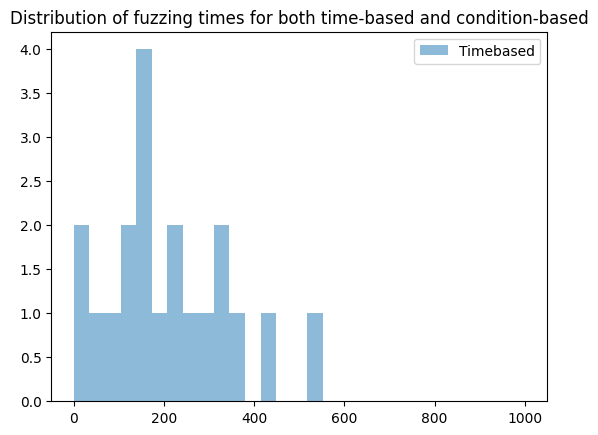

In [ ]:
# Plot the times for condition-based fuzzing for both condition-based and time-based fuzzing
condbased_times = timebased_res["fuzzOpTimes"]

bins = np.linspace(0, 1000, 30)
plt.hist(condbased_times, bins, alpha=0.5, label='Timebased')
plt.title("Distribution of fuzzing times for both time-based and condition-based")
plt.legend(loc='upper right')
plt.show()


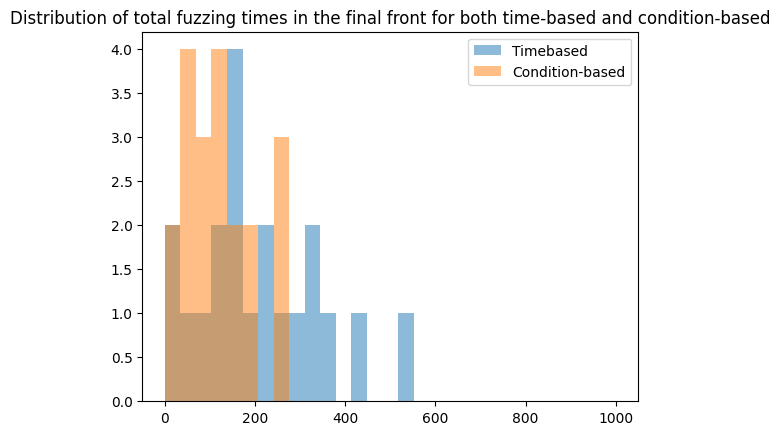

In [ ]:
# Plot the times for condition-based fuzzing for both condition-based and time-based fuzzing
timebased_times = timebased_res["fuzzOpTimes"]
condbased_times = condbased_res["fuzzOpTimes"]

bins = np.linspace(0, 1000, 30)
plt.hist(timebased_times, bins, alpha=0.5, label='Timebased')
plt.hist(condbased_times, bins, alpha=0.5, label='Condition-based')
plt.title("Distribution of total fuzzing times in the final front for both time-based and condition-based")
plt.legend(loc='upper right')
plt.show()


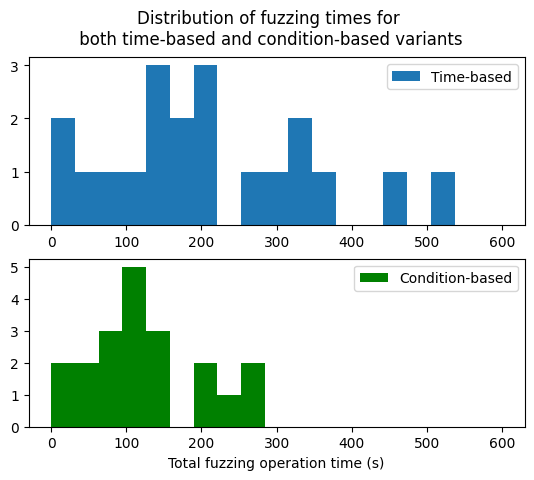

In [ ]:
fig, axes = plt.subplots(2, 1)
# Plot the times for condition-based fuzzing for both condition-based and time-based fuzzing
timebased_times = timebased_res["fuzzOpTimes"]
condbased_times = condbased_res["fuzzOpTimes"]

plt.suptitle("Distribution of fuzzing times for\n both time-based and condition-based variants")
bins = np.linspace(0, 600, 20)
axes[0].hist(timebased_times, bins, alpha=1.0, label='Time-based')
axes[0].legend(loc='upper right')
#axes[0].set(xlabel="Total fuzzing operation time (s)")

axes[1].hist(condbased_times, bins, alpha=1.0, color="green", label='Condition-based')
axes[1].legend(loc='upper right')
axes[1].set(xlabel="Total fuzzing operation time (s)")
plt.savefig("rq2-fuzzing-times.pdf")
plt.show()


In [ ]:
a = np.array([1,2,3])
b = np.array([4,5,6])
a / b

array([0.25, 0.4 , 0.5 ])

In [ ]:
def get_metric_time_ratios(res_df, metric_dfname):
    metric_time_ratio = res_df[metric_dfname] / res_df["fuzzOpTimes"]
    return metric_time_ratio

In [ ]:
timebased_ratios_human = get_metric_time_ratios(timebased_res, "uvExcessHuman")
condbased_ratios_human = get_metric_time_ratios(condbased_res, "uvExcessHuman")
timebased_ratios_surface = get_metric_time_ratios(timebased_res, "uvMissSurface")
condbased_ratios_surface = get_metric_time_ratios(condbased_res, "uvMissSurface")

In [ ]:
def plot_relative_ratios(timebased_ratio, timebased_label, condbased_ratio, condbased_label, xlabel, xmax, fig_filename):
    fig, axes = plt.subplots(2, 1)
    # Plot the times for condition-based fuzzing for both condition-based and time-based fuzzing

    plt.suptitle("Distribution of fuzzing metric ratios\n for both time-based and condition-based variants")
    bins = np.linspace(0, xmax, 20)
    axes[0].hist(timebased_ratio, bins, alpha=1.0, label=timebased_label)
    axes[0].legend(loc='upper right')

    axes[1].hist(condbased_ratio, bins, alpha=1.0, color="green", label=condbased_label)
    axes[1].legend(loc='upper right')
    axes[1].set(xlabel=xlabel)
    plt.savefig(fig_filename)
    plt.show()

In [ ]:
timebased_ratios_human

0     0.000000
1     0.000153
2     0.000000
3     0.000000
4     0.072692
5     0.104163
6     0.002042
7     0.019572
8     0.055988
9     0.016733
10    0.038756
11    0.059411
12    0.068014
13    0.000000
14    0.013984
15    0.060715
16    0.003221
17    0.012427
18    0.022497
19    0.025096
dtype: float64

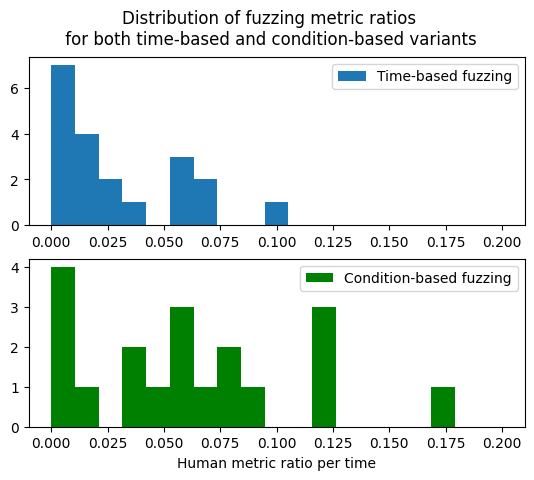

In [ ]:
plot_relative_ratios(timebased_ratios_human, "Time-based fuzzing", condbased_ratios_human, "Condition-based fuzzing", "Human metric ratio per time", 0.2, "rq2_human_metric_ratio.pdf")


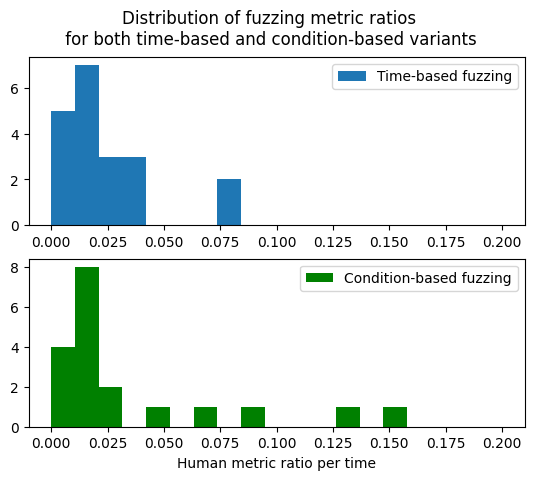

In [ ]:
plot_relative_ratios(timebased_ratios_surface, "Time-based fuzzing", condbased_ratios_surface, "Condition-based fuzzing", "Human metric ratio per time", 0.2, "rq2_human_metric_ratio.pdf")